In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

In [2]:
combined_df = pd.read_csv('combined_df.csv', index_col=0)

C:\Users\David C. Buehler\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2855212 entries, 0 to 2855211
Data columns (total 46 columns):
ab_id             int64
b_count           int64
s_count           int64
b_score           int64
batter_id         int64
batter_side       float64
code              object
g_id              int64
inning            int64
on1b              float64
on2b              float64
on3b              float64
p_score           int64
pitch_type        object
pitcher_id        int64
pitcher_side      float64
ptype             object
px                float64
pz                float64
top               float64
target            int64
pitcher_ahead     float64
pitcher_behind    float64
CH                float64
CU                float64
EP                float64
FA                float64
FC                float64
FF                float64
FO                float64
FS                float64
FT                float64
IN                float64
KC                float64
KN                float64


In [4]:
model_list = [LogisticRegression(), RidgeClassifier()]

In [5]:
def split_data(df, target_variable, **kwargs):
    
    '''
    Using train_test_split with stratify to keep class representation in the data the same across training
    and testing data.
    '''
    
    if kwargs:
        kwarg_list = list(kwargs.items())
        df = df[(df[kwarg_list[0][0]] == kwarg_list[0][1]) & 
                (df[kwarg_list[1][0]] == kwarg_list[1][1])]
    
    X = df.drop([target_variable, 'ab_id', 'batter_id', 'g_id', 'pitcher_id', 'px', 'pz',
                 'CH', 'CU', 'EP', 'FA', 'FC', 'FF', 'FO', 'FS', 'FT', 'IN',
                 'KC', 'KN', 'PO', 'SC', 'SI', 'SL', 'UN', 'id', 'year', 'target'], axis=1).select_dtypes(exclude='object')
    y = df[target_variable]

    X_tr, X_te, y_tr, y_te = train_test_split(X, y, random_state=47, stratify=y)

    return X_tr, X_te, y_tr, y_te

In [6]:
def find_best_params(df, model_list, target_variable, **kwargs):
    
    """
    Finding the best parameters of the models using cross validation to find the most accurate models
    """
    
    X_train, X_test, y_train, y_test = split_data(df, target_variable, **kwargs)
    
    best_C_list = []
    best_alpha_list = []
    
    for model in model_list:
        if model == model_list[0]:
            steps = [('clf', LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=10000, random_state=11))]
            param_grid = {'clf__C': [.0001, .001, .01, .1]}

            pipeline = Pipeline(steps)
            cv = GridSearchCV(pipeline, param_grid, cv=3)
            cv.fit(X_train, y_train)

            best_C = cv.best_params_['clf__C']
            best_C_list.append(best_C)

        elif model == model_list[1]:
            steps = [('ridge', RidgeClassifier(random_state=11))]
            param_grid = {'ridge__alpha': np.arange(10,100,10)}

            pipeline = Pipeline(steps)
            cv = GridSearchCV(pipeline, param_grid, cv=3)
            cv.fit(X_train, y_train)

            best_alpha = cv.best_params_['ridge__alpha']
            best_alpha_list.append(best_alpha)  
                    
    best_params_df = pd.DataFrame({'Logistic Regression': best_C_list, 'Ridge Classifier': best_alpha_list})
            
    return best_params_df

In [7]:
def get_model_accuracies(df, model_list, target_variable, **kwargs):
    
    '''
    Gives a data frame featuring the accuracies of the models
    '''
    
    best_params_df = find_best_params(df, model_list, target_variable, **kwargs)
    
    X_train, X_test, y_train, y_test = split_data(df, target_variable, **kwargs)

    best_C = best_params_df.iloc[0]['Logistic Regression']
    best_alpha = best_params_df.iloc[0]['Ridge Classifier']

    clf = LogisticRegression(C=best_C, solver='lbfgs', multi_class='auto', max_iter=10000, random_state=11).fit(X_train, y_train)
    rlf = RidgeClassifier(alpha=best_alpha, random_state=11).fit(X_train, y_train)

    clf_training_score = clf.score(X_train, y_train)
    clf_testing_score = clf.score(X_test, y_test)
    rlf_training_score = rlf.score(X_train, y_train)
    rlf_testing_score = rlf.score(X_test, y_test)
    
    scores_df = pd.DataFrame({'Logistic Regression Training Scores': clf_training_score, 
                              'Logistic Regression Testing Scores': clf_testing_score,
                              'Ridge Classifier Training Scores': rlf_training_score,
                              'Ridge Classifier Testing Scores': rlf_testing_score},
                              index=['combined_df'])
    scores_df = scores_df.transpose()
    
    return scores_df

In [8]:
def get_confusion_matrix(df, model_list, target_variable, **kwargs):
    
    '''
    Gives confusion matrices and classification reports for the models in use
    '''
    
    X_train, X_test, y_train, y_test = split_data(df, target_variable, **kwargs)
    
    best_params_df = find_best_params(df, model_list, target_variable, **kwargs)
    
    best_C = best_params_df.iloc[0]['Logistic Regression']
    best_alpha = best_params_df.iloc[0]['Ridge Classifier']

    logit = LogisticRegression(C=best_C, solver='lbfgs', multi_class='auto', max_iter=10000, random_state=11)
    ridge = RidgeClassifier(alpha=best_alpha, random_state=11)

    clf = logit.fit(X_train, y_train)
    rlf = ridge.fit(X_train, y_train)
    
    logit_predict = logit.predict(X_test)
    ridge_predict = ridge.predict(X_test)

    lcm = confusion_matrix(logit_predict, y_test)
    rcm = confusion_matrix(ridge_predict, y_test)

    plt.figure(figsize=(9,9))
    sns.heatmap(lcm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Logistic Regression Accuracy Score: {0}'.format(logit.score(X_test, y_test))
    plt.title(all_sample_title, size = 15)
    plt.show()

    plt.figure(figsize=(9,9))
    sns.heatmap(rcm, annot=True, fmt=".3f", linewidths=.5, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Ridge Classifier Accuracy Score: {0}'.format(ridge.score(X_test, y_test))
    plt.title(all_sample_title, size = 15)
    plt.show()
    
    target_names = logit.classes_
    print('Logistic Regression Classification Report:')
    print(classification_report(y_test, logit_predict, target_names=target_names))
    print('Ridge Classifier Classification Report:')
    print(classification_report(y_test, ridge_predict, target_names=target_names))

Now that we have all of our functions outlined, let's put them to use. First we're going to look at every pitcher in our data set and see how predictable the MLB is as a whole. 

In [9]:
get_model_accuracies(combined_df, model_list, 'pitch_type')

,combined_df
Logistic Regression Training Scores,0.556565
Logistic Regression Testing Scores,0.556146
Ridge Classifier Training Scores,0.555960
Ridge Classifier Testing Scores,0.555608


Both models come in with an accuracy of around 56%. That's not great. However just accuracy alone doesn't give us the whole picture. Confusion matrices and classification reports will give us more information.

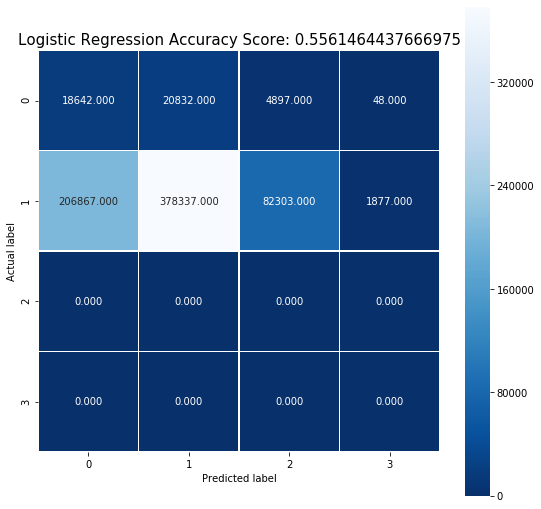

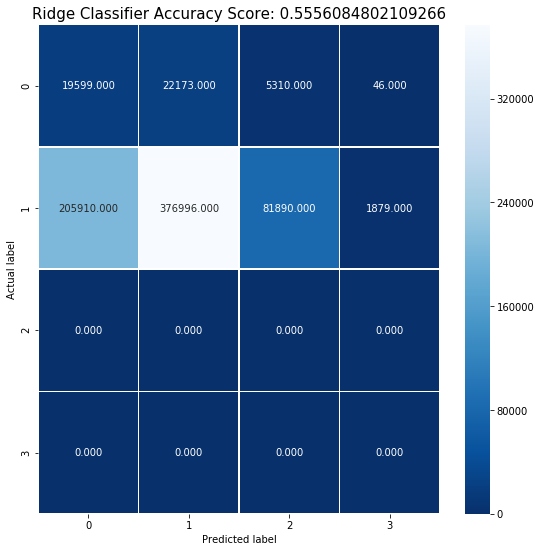

Logistic Regression Classification Report:


C:\Users\David C. Buehler\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

          BB       0.42      0.08      0.14    225509
          FB       0.57      0.95      0.71    399169
          OS       0.00      0.00      0.00     87200
          OT       0.00      0.00      0.00      1925

    accuracy                           0.56    713803
   macro avg       0.25      0.26      0.21    713803
weighted avg       0.45      0.56      0.44    713803

Ridge Classifier Classification Report:
              precision    recall  f1-score   support

          BB       0.42      0.09      0.14    225509
          FB       0.57      0.94      0.71    399169
          OS       0.00      0.00      0.00     87200
          OT       0.00      0.00      0.00      1925

    accuracy                           0.56    713803
   macro avg       0.25      0.26      0.21    713803
weighted avg       0.45      0.56      0.44    713803



In [10]:
get_confusion_matrix(combined_df, model_list, 'pitch_type')

Neither model even guessed offspeed pitches or other pitches for the entire data set. But got 95% of fastballs and only 8%-9% of breaking balls with bad precisions for both of them. This could be because of the huge class imbalance in the data set, with offspeed pitches only being about 12% of the entire dataset, and other pitches being less than 1%. Whereas fastball take up the majority of the data set. Overall these results make sense, as the majority of the time pitchers are throwing fastballs, so the model could just predict a pitch is going to be a fastball and it's a likely bet that that's what actually happened.

That was for the entire data set, now let's take a look at individual pitchers, looking at my favorite pitcher first, Felix Hernandez.

In [11]:
get_model_accuracies(combined_df, model_list, 'pitch_type', first_name='Felix', last_name='Hernandez')

,combined_df
Logistic Regression Training Scores,0.464417
Logistic Regression Testing Scores,0.468022
Ridge Classifier Training Scores,0.464982
Ridge Classifier Testing Scores,0.465904


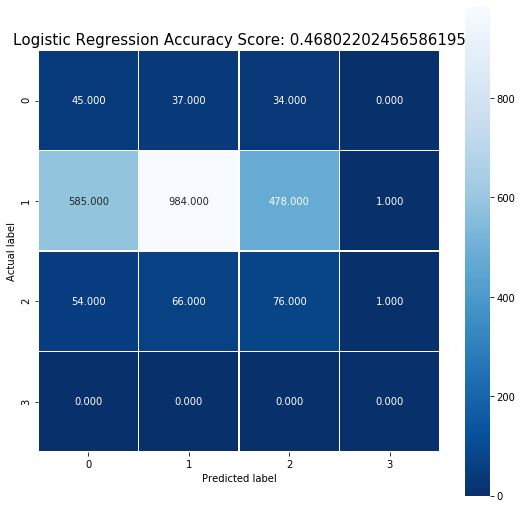

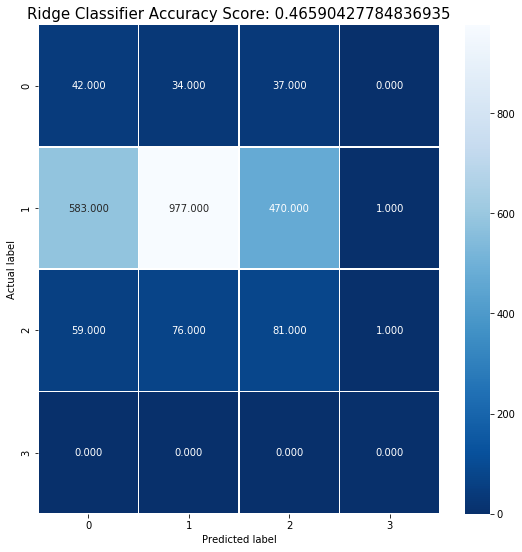

Logistic Regression Classification Report:
              precision    recall  f1-score   support

          BB       0.39      0.07      0.11       684
          FB       0.48      0.91      0.63      1087
          OS       0.39      0.13      0.19       588
          OT       0.00      0.00      0.00         2

    accuracy                           0.47      2361
   macro avg       0.31      0.28      0.23      2361
weighted avg       0.43      0.47      0.37      2361

Ridge Classifier Classification Report:
              precision    recall  f1-score   support

          BB       0.37      0.06      0.11       684
          FB       0.48      0.90      0.63      1087
          OS       0.37      0.14      0.20       588
          OT       0.00      0.00      0.00         2

    accuracy                           0.47      2361
   macro avg       0.31      0.27      0.23      2361
weighted avg       0.42      0.47      0.37      2361



C:\Users\David C. Buehler\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
get_confusion_matrix(combined_df, model_list, 'pitch_type', first_name='Felix', last_name='Hernandez')

Here we see a much smaller data set, only 2,362 pitches predicted instead of 714,000. However, even with this fact, and that the model seemed to be able to predict offspeed pitches correctly this time around, it still had a worse overall time than the entire data set. Felix Hernandez hasn't been on the top of his game from 2015-2019, though not the worst pitcher, it still seems like he's not very predictable in the eyes of machine learning. 

In [13]:
get_model_accuracies(combined_df, model_list, 'pitch_type', first_name='Justin', last_name='Verlander')

,combined_df
Logistic Regression Training Scores,0.600814
Logistic Regression Testing Scores,0.602568
Ridge Classifier Training Scores,0.600606
Ridge Classifier Testing Scores,0.601629


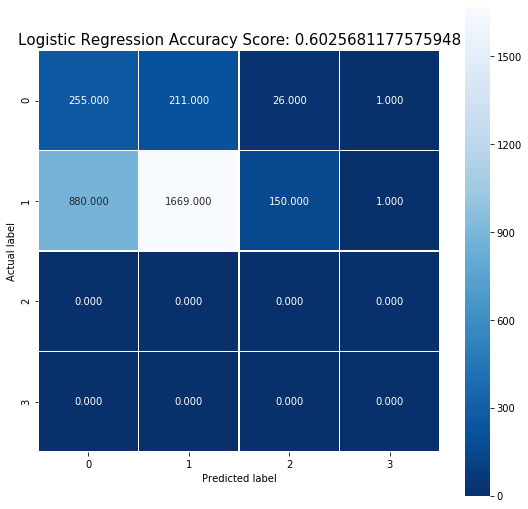

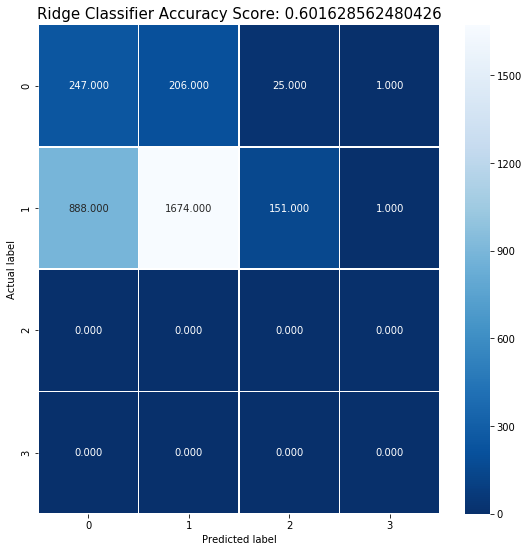

Logistic Regression Classification Report:
              precision    recall  f1-score   support

          BB       0.52      0.22      0.31      1135
          FB       0.62      0.89      0.73      1880
          OS       0.00      0.00      0.00       176
          OT       0.00      0.00      0.00         2

    accuracy                           0.60      3193
   macro avg       0.28      0.28      0.26      3193
weighted avg       0.55      0.60      0.54      3193

Ridge Classifier Classification Report:
              precision    recall  f1-score   support

          BB       0.52      0.22      0.31      1135
          FB       0.62      0.89      0.73      1880
          OS       0.00      0.00      0.00       176
          OT       0.00      0.00      0.00         2

    accuracy                           0.60      3193
   macro avg       0.28      0.28      0.26      3193
weighted avg       0.55      0.60      0.54      3193



C:\Users\David C. Buehler\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
get_confusion_matrix(combined_df, model_list, 'pitch_type', first_name='Justin', last_name='Verlander')

I went in to this project thinking that better pitchers would be less predictable than those not as good, and we have an example of the opposite right here. Felix Hernandez, being an objectively worse pitcher than Justin Verlander, was less predictable than Verlander. However, it must be noted that Verlander's class representation is different than Hernandez's. Verlander here throws mostly 2 pitches, whereas Felix had a good mix of 3 pitches. I think that led to Verlander being more predictable in the eyes of the model than Hernandez was.  

Let's take a look at another pitcher who's also been excellent from 2015 to 2018, Clayton Kershaw

In [15]:
get_model_accuracies(combined_df, model_list, 'pitch_type', first_name='Clayton', last_name='Kershaw')

,combined_df
Logistic Regression Training Scores,0.631456
Logistic Regression Testing Scores,0.608797
Ridge Classifier Training Scores,0.630288
Ridge Classifier Testing Scores,0.609576


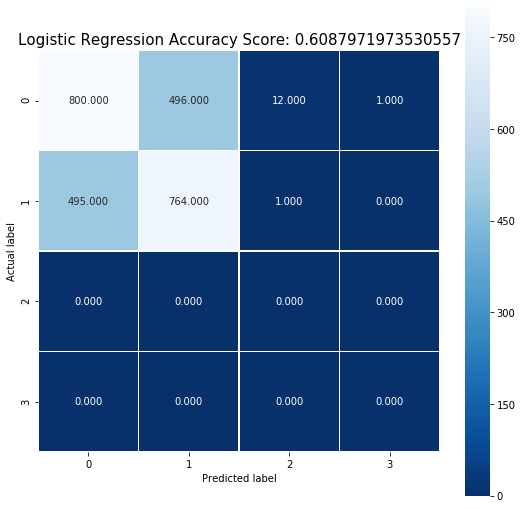

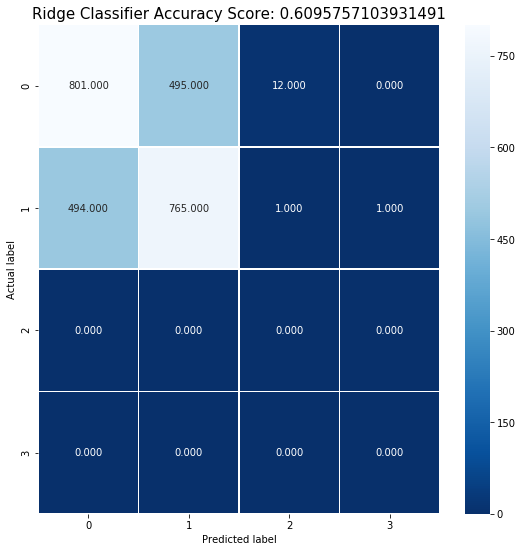

Logistic Regression Classification Report:
              precision    recall  f1-score   support

          BB       0.61      0.62      0.61      1295
          FB       0.61      0.61      0.61      1260
          OS       0.00      0.00      0.00        13
          OT       0.00      0.00      0.00         1

    accuracy                           0.61      2569
   macro avg       0.30      0.31      0.31      2569
weighted avg       0.61      0.61      0.61      2569

Ridge Classifier Classification Report:
              precision    recall  f1-score   support

          BB       0.61      0.62      0.62      1295
          FB       0.61      0.61      0.61      1260
          OS       0.00      0.00      0.00        13
          OT       0.00      0.00      0.00         1

    accuracy                           0.61      2569
   macro avg       0.30      0.31      0.31      2569
weighted avg       0.61      0.61      0.61      2569



C:\Users\David C. Buehler\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
get_confusion_matrix(combined_df, model_list, 'pitch_type', first_name='Clayton', last_name='Kershaw')

About the same as Verlander. An excellent pitcher who's stayed consistently good from 2015-2018 being less predictable with only 62% predictability on both models. It seems to be about the same story as Verlander too, with Kershaw throwing an about even number of fastballs and breaking balls, it makes sense the accuracies of the models would be similar, or basically the same.

So we've taken a look at 2 of the top pitchers in the MLB, and one who hasn't been great over the last 4 years, and it seems like the better pitchers have so far been less predictable. Let's take a look at two other pitchers who haven't been as good as Verlander or Kershaw over these 4 seasons, as well as aren't starting pitchers who are instead relievers and closers.

First up is New York Mets closer Edwin Diaz. He's a good young closer who's been pitching in the MLB since 2016, and winning the AL Reliever of the Year award in 2018 when he was with Seattle. 

In [17]:
get_model_accuracies(combined_df, model_list, 'pitch_type', first_name='Edwin', last_name='Diaz')

,combined_df
Logistic Regression Training Scores,0.680626
Logistic Regression Testing Scores,0.685279
Ridge Classifier Training Scores,0.681049
Ridge Classifier Testing Scores,0.677665


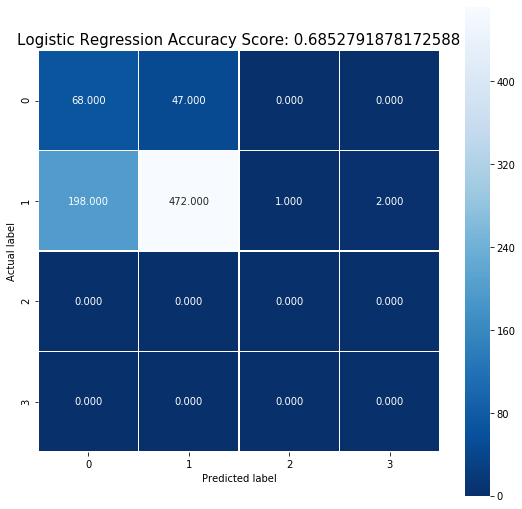

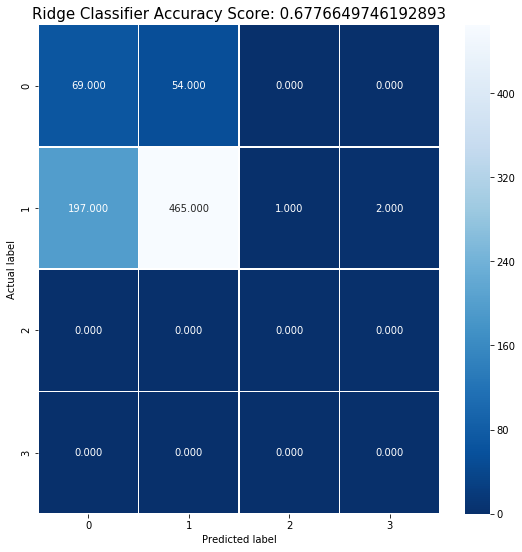

Logistic Regression Classification Report:
              precision    recall  f1-score   support

          BB       0.59      0.26      0.36       266
          FB       0.70      0.91      0.79       519
          OS       0.00      0.00      0.00         1
          OT       0.00      0.00      0.00         2

    accuracy                           0.69       788
   macro avg       0.32      0.29      0.29       788
weighted avg       0.66      0.69      0.64       788

Ridge Classifier Classification Report:
              precision    recall  f1-score   support

          BB       0.56      0.26      0.35       266
          FB       0.70      0.90      0.79       519
          OS       0.00      0.00      0.00         1
          OT       0.00      0.00      0.00         2

    accuracy                           0.68       788
   macro avg       0.32      0.29      0.29       788
weighted avg       0.65      0.68      0.64       788



C:\Users\David C. Buehler\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
get_confusion_matrix(combined_df, model_list, 'pitch_type', first_name='Edwin', last_name='Diaz')

Similar story to the two pitchers that came before him, only throws fastballs and breaking balls and the model has an easier time predicting 2 classes than 3. It seems like as the sample size gets smaller and pitchers are only throwing 2 types of pitches, the models will generally be more accurate.

How about Aroldis Chapman? He's been one of the best closers in baseball for a long time, let's see how predictable he's been since 2015.

In [19]:
get_model_accuracies(combined_df, model_list, 'pitch_type', first_name='Aroldis', last_name='Chapman')

C:\Users\David C. Buehler\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\David C. Buehler\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


,combined_df
Logistic Regression Training Scores,0.768446
Logistic Regression Testing Scores,0.768603
Ridge Classifier Training Scores,0.768446
Ridge Classifier Testing Scores,0.768603


C:\Users\David C. Buehler\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
C:\Users\David C. Buehler\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


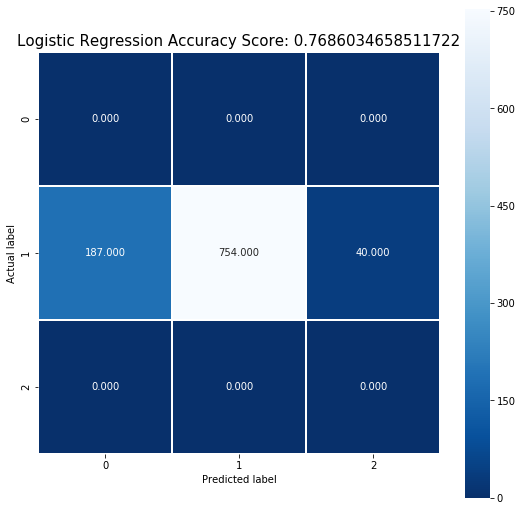

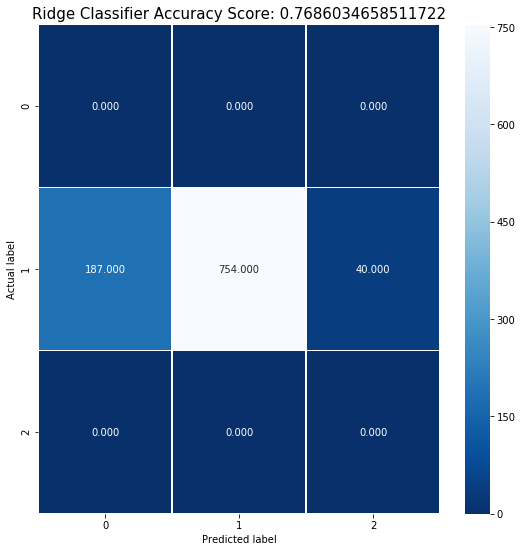

Logistic Regression Classification Report:


ValueError: Number of classes, 3, does not match size of target_names, 4. Try specifying the labels parameter

In [20]:
get_confusion_matrix(combined_df, model_list, 'pitch_type', first_name='Aroldis', last_name='Chapman')

Here we have an example of a pitcher who basically only throws fastballs. Aroldis Chapman throughout his time in the MLB has had one of the biggest arms in the game. Consistently throwing 100+ mph fastballs, which even for professional hitters are almost impossible to hit, so why not keep throwing them? Apparently the model on Chapman just predicted all fastballs, since that was the vast majority of the pitches thrown by him, and called it good enough. 

## Final thoughts

There seems to be a bit of a correlation to how many pitches a pitcher throws on a regular basis and how predictable they are. Looking at Felix Hernandez, he pretty consistently throws three types of pitches, and he was predicted at a 46% accuracy, with most of his fastballs being correctly guessed, but the majority of his breaking balls and offspeed pitches being incorrectly guessed. Compared to Clayton Kershaw and Justin Verlander, who usually throw two types of pitches, the model predicted their pitches at 62% and 60% accuracy respectively. It seems to be broken up across pitcher positions as well (starters vs. relievers). Hernandez, Verlander, and Kershaw are all starting pitchers, but looking at the two relievers we did, Diaz and Chapman, there was a disparity on accuracies. Diaz and Chapman were predicted with a higher accuracy than those of the starters, about 68% and 77% respectively. This could be due to the sample size, closers and relievers don't throw nearly as many pitches as starters, especially the better ones like Kershaw and Verlander. More analysis will be done to see a more clear trend on better pitchers vs. worse pitchers and see if relievers are really this predictable.